In [1]:
import pandas as pd
import polars as pl
import json, re, shutil, os, pprint

from utils import *


In [2]:
# Matches the language abreviation at start of filename
regex = "(?<=\/)[a-z]{2,3}(?=_)|$"

europe_languages = ["Dutch", "French", "German", "Italian", "Danish", "English",
"Greek", "Portuguese", "Spanish", "Finnish", "Swedish", "Czech", "Estonian",
"Hungarian", "Latvian", "Lithuanian", "Maltese", "Polish", "Slovak", "Slovenian",
"Bulgarian", "Irish", "Romanian", "Croatian"]

# reverse key for lg:language equivalence
lg_dict = {v:k for k,v in lang_dict.items()}


# UD Perplexities

In [8]:
df = pd.read_json('./pps/pt_pp_docs.json')
df.head()

,doc_id,pp_score,language
0,./filter_ud/UD_Portuguese-PetroGold/UD_Portugu...,8570,Portuguese
1,./filter_ud/UD_Portuguese-Bosque/UD_Portuguese...,4580,Portuguese
2,./filter_ud/UD_Portuguese-CINTIL/UD_Portuguese...,7679,Portuguese
3,./filter_ud/UD_Portuguese-PUD/UD_Portuguese-PU...,3911,Portuguese
4,./filter_ud/UD_Portuguese-GSD/UD_Portuguese-GS...,3271,Portuguese


# Adult copurs perplexity

# Example

This session loads and recovers the perplexity for one of the jsonl files created
for the oscar-corpus containing only adult content

In [6]:
dfpl = pl.read_ndjson("/netscratch/fonseca/oscar-pre-processing/adult-oscar/pt_meta/pt_meta_part_1.jsonl")

[/home/runner/work/polars/polars/polars/polars-io/src/ndjson/core.rs:162] &data_type = Struct(
    [
        Field {
            name: "content",
            data_type: LargeUtf8,
            is_nullable: true,
            metadata: {},
        },
        Field {
            name: "warc_headers",
            data_type: Struct(
                [
                    Field {
                        name: "content-length",
                        data_type: LargeUtf8,
                        is_nullable: true,
                        metadata: {},
                    },
                    Field {
                        name: "warc-block-digest",
                        data_type: LargeUtf8,
                        is_nullable: true,
                        metadata: {},
                    },
                    Field {
                        name: "warc-record-id",
                        data_type: LargeUtf8,
                        is_nullable: true,
                        metadata:

In [8]:
dfpl.head()

content,warc_headers,metadata
str,struct[9],struct[6]
"""Curta os Video…","{""632"",""sha1:SRE3EEUCJWLRVFUOX5NNEQEHTEBBHI4D"",""<urn:uuid:c3cdf787-10cf-4502-9416-87e683de9577>"",""conversion"",""<urn:uuid:30e9dd23-91c5-4a4e-89f6-6438160d8a04>"",""2022-11-29T00:58:28Z"",""por"",""https://salvandosuabronha.com/boquete-sexo/"",""text/plain""}","{{""pt"",0.982402},570.64935,""tlsh:T1AACC5DF0DD49C5C00EFE191BCE5B02301C4339C7ABE7EAE0A38B276AE0B82EF11BA616BF802412D301909A10208D7F84C41277CC88936648C991B92B4B0520C4205BB369D2"",[""porn"", ""adult""],[{""pt"",0.9824022}],[""tiny""]}"
"""Comendo Entead…","{""1883"",""sha1:OUDV6VSEID3POYYNPHWJFX55CSLNSDDQ"",""<urn:uuid:48a2d3ff-2ac2-4e67-a31e-a9b6349d00c6>"",""conversion"",""<urn:uuid:b2bbe819-3e66-4d2e-b6d6-289ad4af243a>"",""2022-11-29T00:17:15Z"",""por"",""https://www.xvideos-tv.com/comendo-enteada/"",""text/plain""}","{{""pt"",0.7535834},1769.4886,""tlsh:T152451D41321DBC155F6016A5DA4F97C06827FD96E6D5DFE402CA632FC0BC3EA92ED7759F720816C98163476123C47B93C283D9CDD40A521B8EC2A4E74A1630C8588D53E36E"",[""porn"", ""adult""],[{""pt"",0.9837137}, {null,null}, … {""pt"",0.9325305}],[""short_sentences"", ""header"", ""footer""]}"
"""A excomunhão d…","{""3594"",""sha1:FJB4MOLN73DHCVHWTB4XHDTYDHI6MIM4"",""<urn:uuid:68b496c7-3aef-4cd9-a3ce-61e5c23ade0f>"",""conversion"",""<urn:uuid:018f4cb8-dbd5-4eb1-a650-b44ad63d2e56>"",""2022-11-26T12:02:30Z"",""por"",""https://portugalgay.pt/news/270906A/eua_catolicismo_pouco_preocupado_em_relacao_a_excomunhao_de_padres_casados"",""text/plain""}","{{""pt"",0.78423},2884.5542,""tlsh:T12758B271A737F92C7EE18A87F66B039028BCE415EA716FCAF31F722450AA3E751AC98C35AB291F442252391303C126029793ECA9C68CFE99C1E6ED7B580712DC9499569F50"",[""porn"", ""adult""],[{""pt"",0.9929545}, {""pt"",0.9038146}, … {null,null}],[""footer""]}"
"""Neste vídeo po…","{""2938"",""sha1:JSXYLGENYAIRBMH5JCNM46TVUA75VKM2"",""<urn:uuid:3af3a890-1a4b-4454-9f5c-c2a2973815b0>"",""conversion"",""<urn:uuid:1b4a4559-decb-4b4d-b4b9-83fd5f46e3dc>"",""2022-12-08T07:25:33Z"",""por"",""https://favelaporno.com/marido-de-tacristinalmeida-deu-ela-para-um-negro-de-pau-grande/"",""text/plain""}","{{""pt"",0.804617},1031.9656,""tlsh:T1B994045186197E6CCFB34FC1A8678551A9F9D499B3A0AFFC6183C25A537C78E54B87604902000E8603158DA013DB278ED6939CEF85F2B513C842A2AF871223C95589DB7AB6"",[""adult"", ""porn""],[{""pt"",0.985515}, {null,null}, … {""pt"",0.9785557}],[""short_sentences"", ""header"", ""footer""]}"
"""Para criar um …","{""11890"",""sha1:4B6YLVZ6NF4WAID4XHCYZP7AK6MHX53Y"",""<urn:uuid:49528c6d-edcb-4346-8923-f39a4d465071>"",""conversion"",""<urn:uuid:cd035221-3c13-44e1-a69c-77b79e673df5>"",""2022-12-07T10:38:06Z"",""por"",""https://fatalmodel.com/386290/alexander-386290"",""text/plain""}","{{""pt"",0.8556691},1575.4915,""tlsh:T19DF4B032A5199A292FF70748991F4B514A75F6D8F0DDA594C22F6397426D7E968A78222ACB3885EA033B44330391B759C723964CC241B64DD5C7C7FE0F8C06CD981EF3EE92"",[""adult"", ""porn""],[{""pt"",0.9884776}, {""pt"",0.8932468}, … {""pt"",0.9992112}],[""short_sentences"", ""header"", ""footer""]}"


In [9]:
# filtering out the nested JSONS

harmful_pp_list = list(map(return_pp, dfpl[:,2]))

In [10]:
# recovering a smalled dataframe with only the relevant information for now
new_df = pl.DataFrame({'content': dfpl[:,0], 'harmful_pp':harmful_pp_list})

In [11]:
new_df.head()

content,harmful_pp
str,f64
"""Curta os Video…",570.64935
"""Comendo Entead…",1769.4886
"""A excomunhão d…",2884.5542
"""Neste vídeo po…",1031.9656
"""Para criar um …",1575.4915


In [12]:
new_df.mean()

content,harmful_pp
str,f64
null,2482.138421


# Perplexity for all languages

Extracting perplexity for adult-oscar 

> If the file is already created skip to the load cells

In [3]:
import logging, pickle

logging.basicConfig(level=logging.DEBUG,filename='adult_perplexity.log')


In [4]:
# Caution, this block takes around 15minutes to run on the batch node

# Loading Paths
f_paths = []
for root, dirnames, files in os.walk("./adult-oscar/"):
    for file in files:
        f_paths.append(os.path.join(root,file))

# Reading 
dict_means = {}
dict_full = {}
for path in f_paths:
    # check which language from path applying the regex
    lg = re.findall(regex,path)[0]
    # ignores path if can't find the language
    if lg == '':
        continue
    # Creates a key for the dictionary of mean perplexity for each language
    if lg not in dict_means.keys():
        dict_means[lg] = []
        dict_full[lg] = []

    # try block for reading the json from the adult corpus
    try:
        dataframe = pl.read_ndjson(path)
        # Gets the perplexity of each document as a list
        harmful_pp_list = list(map(return_pp, dataframe[:,2]))
    except RuntimeError as r:
        # Runtime errors are raised when the read_ndjson method cannot read it
        # completely (most likely requires a re run of the create_adul_ds.py for
        # this specific language)
        logging.warning("{}:\n{}".format(r ,path))
        continue
    except KeyError as k:
        logging.warning("{}:{}".format(k ,path))
        continue

    dict_full[lg].extend(harmful_pp_list)
    dict_means[lg].append(sum(harmful_pp_list)/len(harmful_pp_list))

c_dict_means = {lg: sum(means)/len(means) for (lg,
         means) in dict_means.items() if len(means) != 0}

[/home/runner/work/polars/polars/polars/polars-io/src/ndjson/core.rs:162] &data_type = Struct(
    [
        Field {
            name: "content",
            data_type: LargeUtf8,
            is_nullable: true,
            metadata: {},
        },
        Field {
            name: "warc_headers",
            data_type: Struct(
                [
                    Field {
                        name: "warc-target-uri",
                        data_type: LargeUtf8,
                        is_nullable: true,
                        metadata: {},
                    },
                    Field {
                        name: "warc-date",
                        data_type: LargeUtf8,
                        is_nullable: true,
                        metadata: {},
                    },
                    Field {
                        name: "warc-type",
                        data_type: LargeUtf8,
                        is_nullable: true,
                        metadata: {},
       

In [5]:
# saving the perplexity 
# commented out so I don't accidentally overwrite the file

# with open('./adult_pp_dict.pkl', 'wb') as file:
#     pickle.dump(c_dict_means,file)

# with open('./adult_pp_dict_full.pkl', 'wb') as file:
#     pickle.dump(dict_full,file)

## Load the dictionary with perplexity for adult-oscar content

In [6]:
# Load dict
with open('./adult_pp_dict.pkl', 'rb') as file:
    c_dict_means = pickle.load(file)

with open('./adult_pp_dict_full.pkl', 'rb') as file:
    dict_full = pickle.load(file)

#filtering official eu languages
eu_lg = [lang_dict[l] for l in europe_languages]
eu_pps = {key:value for key,value in c_dict_means.items() if key in eu_lg}

In [35]:
#
eu_pps = {lg_dict[key]:pp for key,pp in eu_pps.items()}
pprint.pprint(eu_pps)

{'Bulgarian': 6477.285412765637,
 'Czech': 18454.28785890177,
 'Danish': 3446.3530769948893,
 'Dutch': 1951.7184170565697,
 'English': 1321.848530311227,
 'Estonian': 5254.884522946542,
 'Finnish': 10096.609868553292,
 'French': 1828.8094992694703,
 'German': 3865.0844278517334,
 'Greek': 9700.148223445325,
 'Hungarian': 13742.707306890257,
 'Italian': 4912.9487112597,
 'Latvian': 4375.965811636749,
 'Lithuanian': 32722.90585405496,
 'Polish': 10504.465567390756,
 'Portuguese': 2551.497857495963,
 'Romanian': 3289.5020744583003,
 'Slovak': 11482.729111494735,
 'Slovenian': 1855.1647045403718,
 'Spanish': 3194.186531106972,
 'Swedish': 6507.748918533279}


# Perplexities from UD

In [10]:
# Reading the paths

f_paths = []
for root, dirnames, files in os.walk("./pps/"):
    for file in files:
        if "docs" in file:
            f_paths.append(os.path.join(root,file))

dfs = [pd.read_json(path) for path in f_paths]

In [5]:
all_ud_pps = pd.concat(dfs, ignore_index=True)

In [6]:
pd.set_option('display.max_rows', None)
pprint.pprint(all_ud_pps)

                                               doc_id  pp_score    language
0   ./filter_ud/UD_Polish-PUD/UD_Polish-PUD-concat...   30024.0      Polish
1   ./filter_ud/UD_Polish-PDB/UD_Polish-PDB-concat...   22374.0      Polish
2   ./filter_ud/UD_Polish-LFG/UD_Polish-LFG-concat...   23359.0      Polish
3   ./filter_ud/UD_Estonian-EWT/UD_Estonian-EWT-co...    6450.0    Estonian
4   ./filter_ud/UD_Estonian-EDT/UD_Estonian-EDT-co...    8239.0    Estonian
5   ./filter_ud/UD_Dutch-Alpino/UD_Dutch-Alpino-co...    5748.0       Dutch
6   ./filter_ud/UD_Frisian_Dutch-Fame/UD_Frisian_D...   96953.0       Dutch
7   ./filter_ud/UD_Dutch-LassySmall/UD_Dutch-Lassy...   13353.0       Dutch
8   ./filter_ud/UD_Italian-ISDT/UD_Italian-ISDT-co...    4702.0     Italian
9   ./filter_ud/UD_Italian-ParlaMint/UD_Italian-Pa...    2667.0     Italian
10  ./filter_ud/UD_Italian-PUD/UD_Italian-PUD-conc...    4637.0     Italian
11  ./filter_ud/UD_Italian-PoSTWITA/UD_Italian-PoS...   11490.0     Italian
12  ./filter

In [11]:
print(all_ud_pps.groupby('language').mean())

                 pp_score
language                 
Bulgarian     8211.000000
Czech        29051.000000
Danish        3886.000000
Dutch        38684.666667
English       2821.000000
Estonian      7344.500000
Finnish      33856.500000
French       16399.222222
German       90960.833333
Greek       160233.666667
Hungarian    20491.000000
Italian       5407.000000
Latvian      16630.000000
Lithuanian   69717.000000
Polish       25252.333333
Portuguese    5602.200000
Romanian     24557.000000
Slovak       32766.000000
Slovenian     3304.500000
Spanish       2492.666667
Swedish       9553.333333


> frisian dutch is not the dominant variety  
- 6   ./new_/UD_Frisian_Dutch-Fame/UD_Frisian_Dutch-...   96960.0       Dutch  

> Contains a lot of twitter links  
- 11  ./new_/UD_Italian-PoSTWITA/UD_Italian-PoSTWITA...   12160.0     Italian  
- 12  ./new_/UD_Italian-TWITTIRO/UD_Italian-TWITTIRO...   11627.0     Italian  

> Empty files  
- 32  ./new_/UD_English-GUMReddit/UD_English-GUMRedd...      78.0     English  
- 33  ./new_/UD_Hindi_English-HIENCS/UD_Hindi_Englis...       5.0     English  
- 38    ./new_/UD_English-ESL/UD_English-ESL-concat.txt       7.0     English  

> contains only pronouns  
- 40  ./new_/UD_English-Pronouns/UD_English-Pronouns...   10955.0     English  

> Non standard varieties different writing systems  
- 42  ./filter_ud/UD_Romanian-ArT/UD_Romanian-ArT-co...   68409.0    Romanian  
- 43  ./filter_ud/UD_Romanian-Nonstandard/UD_Romania...   15181.0    Romanian  

> We're not dealing with ancient, but modern greek   
- 46  ./new_/UD_Ancient_Greek-PROIEL/UD_Ancient_Gree...  231697.0       Greek  
- 48  ./new_/UD_Ancient_Greek-Perseus/UD_Ancient_Gre...  243466.0       Greek   

> multilingual treebank  
- 50  ./new_/UD_Turkish_German-SAGT/UD_Turkish_Germa...   67073.0      German    

> Swiss german, very different spellings  
- 53  ./filter_ud/UD_Swiss_German-UZH/UD_Swiss_Germa...  432958.0      German  

> Old french  
- 60  ./filter_ud/UD_Old_French-SRCMF/UD_Old_French-...  127478.0      French  

> Has missing words  
- 68  ./filter_ud/UD_French-FTB/UD_French-FTB-concat...     591.0      French  


> Some of those means look suspiciously high, after reading the files and some
> READMEs I decided to drop the following rows

In [13]:
all_ud_pps_filter = all_ud_pps.drop(index=[6,11,12,32,33,38,40,42,43,46,48,50
            ,53,60,68])
print(all_ud_pps_filter.groupby('language').mean())

                pp_score
language                
Bulgarian    8211.000000
Czech       29051.000000
Danish       3886.000000
Dutch        9550.500000
English      2835.666667
Estonian     7344.500000
Finnish     33856.500000
French       2789.142857
German      11425.500000
Greek        5417.000000
Hungarian   20491.000000
Italian      3652.000000
Latvian     16630.000000
Lithuanian  69717.000000
Polish      25252.333333
Portuguese   5602.200000
Romanian     7319.000000
Slovak      32766.000000
Slovenian    3304.500000
Spanish      2492.666667
Swedish      9553.333333


In [37]:
final_df = all_ud_pps_filter.groupby('language').mean().reset_index()

final_df['adult_pp'] = final_df['language'].map(eu_pps)


In [40]:
final_df.adult_pp = final_df.adult_pp.round(2)
final_df.pp_score = final_df.pp_score.round(2)
final_df

,language,pp_score,adult_pp
0,Bulgarian,8211.00,6477.29
1,Czech,29051.00,18454.29
2,Danish,3886.00,3446.35
3,Dutch,9550.50,1951.72
4,English,2835.67,1321.85
5,Estonian,7344.50,5254.88
6,Finnish,33856.50,10096.61
7,French,2789.14,1828.81
8,German,11425.50,3865.08
9,Greek,5417.00,9700.15


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize":(16, 9)}) #width=6, height=5


In [8]:

eu_lg = [lang_dict[l] for l in europe_languages]

print(eu_lg)
dict_full_2 = {lg_dict[key]:value for key,value in dict_full.items() if key in eu_lg}


['nl', 'fr', 'de', 'it', 'da', 'en', 'el', 'pt', 'es', 'fi', 'sv', 'cs', 'et', 'hu', 'lv', 'lt', 'mt', 'pl', 'sk', 'sl', 'bg', 'ga', 'ro', 'hr']


In [9]:
df = pd.DataFrame.from_dict(dict_full_2, orient='index').T
df.head()


,Slovak,English,German,Romanian,Greek,Swedish,Bulgarian,Czech,Estonian,Hungarian,...,Latvian,Slovenian,French,Irish,Lithuanian,Dutch,Italian,Spanish,Croatian,Maltese
0,9264.4330,4.352414,338.26166,1933.523800,16006.789000,1213.784900,8747.104000,158.02592,6325.182600,22171.455000,...,237.430730,4834.8410,418.32892,NaN,16462.057000,965.05460,5105.341000,344.38052,NaN,NaN
1,18595.8630,568.498700,2384.09400,2024.536700,10.665789,4711.566400,94853.350000,158.02592,6325.182600,1.242813,...,392.069270,1492.7633,1638.29980,NaN,104893.390000,332.27084,8.371869,482.97900,NaN,NaN
2,31505.1900,1.932131,138.42040,3126.962400,8817.509000,54710.777000,3487.902800,23136.00200,6325.182600,22642.441000,...,9355.843000,1673.1158,1534.65700,NaN,4.402482,316.95618,8091.260700,3605.35030,NaN,NaN
3,21800.1040,1.578769,6187.86870,5560.051300,2895.342500,1213.784900,7.047749,10989.77800,6325.182600,24443.188000,...,6.807223,1883.4479,220.07141,NaN,130122.590000,487.00735,1.416322,170.52232,NaN,NaN
4,2620.1284,1.551837,6110.24900,19.449299,14437.786000,4.224184,7003.147500,23136.00200,1.714714,6.356946,...,3.097205,2643.6110,3132.86650,NaN,74880.820000,2111.71830,6253.189500,770.73690,NaN,NaN


In [27]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

,Slovak,English,German,Romanian,Greek,Swedish,Bulgarian,Czech,Estonian,Hungarian,...,Latvian,Slovenian,French,Irish,Lithuanian,Dutch,Italian,Spanish,Croatian,Maltese
count,1639.00,2492141.00,162259.00,3132.00,6268.00,3320.00,3298.00,24076.00,1153.00,17575.00,...,596.00,161.00,245352.00,0.00,919.00,38204.00,37825.00,91382.00,0.00,0.00
mean,11482.73,1339.17,3962.46,3289.50,9919.35,6507.75,6477.29,18761.63,5254.88,13741.92,...,4375.97,1855.16,1828.62,NaN,32722.91,1954.22,4970.09,3190.79,NaN,NaN
std,12584.51,46748.57,23249.60,4901.84,14906.28,14360.18,8280.53,21740.76,2041.03,14636.00,...,6090.38,993.27,15190.17,NaN,27250.10,7264.82,25082.20,19163.72,NaN,NaN
min,1.51,1.08,1.09,1.22,1.42,1.84,3.52,1.24,1.71,1.11,...,1.48,3.73,1.06,NaN,1.16,1.14,1.12,1.17,NaN,NaN
25%,3560.84,8.66,273.54,1368.43,338.04,30.79,2014.25,7744.03,4777.77,4335.47,...,21.31,1408.36,248.28,NaN,16462.06,75.85,440.47,292.87,NaN,NaN
50%,8481.41,277.08,1586.93,2202.59,4226.81,1728.41,3260.06,16758.97,6325.18,10495.51,...,810.41,2114.37,548.00,NaN,26045.11,612.03,1916.62,890.16,NaN,NaN
75%,16697.51,837.77,4536.51,3751.12,13232.47,5613.24,8623.61,25014.31,6325.18,20120.88,...,6792.65,2463.78,1338.27,NaN,40923.26,2012.37,4538.58,2093.66,NaN,NaN
max,230507.83,32766206.00,3074749.00,71312.34,85136.20,266686.22,119018.76,385787.00,12609.71,253087.52,...,34327.35,4834.84,3249432.00,NaN,182316.95,974687.44,1183967.90,801921.56,NaN,NaN


In [20]:
df_list = []

for col in df:
    std = df[col].std()
    mean = df[col].mean()
    lower = mean - 1.5*std
    upper = mean + 1.5*std
    df_list.append(df.loc[(df[col] >= lower) &
     (df[col] <= upper)][col])

filter_df = pd.concat(df_list,axis=1)

In [28]:
filter_df.describe()

,Slovak,English,German,Romanian,Greek,Swedish,Bulgarian,Czech,Estonian,Hungarian,...,Latvian,Slovenian,French,Irish,Lithuanian,Dutch,Italian,Spanish,Croatian,Maltese
count,1557.00,2488845.00,161500.00,2999.00,5788.00,3104.00,3148.00,23487.00,990.00,16894.00,...,533.00,130.00,242704.00,0.00,837.00,37376.00,37522.00,90515.00,0.00,0.00
mean,9584.42,905.46,3173.81,2530.34,6110.03,3437.24,5257.19,16409.25,5973.05,11918.69,...,2740.75,2144.80,1276.78,NaN,26165.88,1445.59,3416.04,1703.40,NaN,NaN
std,7658.20,3157.22,4346.40,1988.26,6621.85,4811.64,4752.17,11465.82,917.84,9514.59,...,3659.37,549.99,2333.58,NaN,16666.52,2027.93,4779.33,2463.04,NaN,NaN
min,1.51,1.08,1.09,1.22,1.42,1.84,3.52,1.24,2249.32,1.11,...,1.48,405.84,1.06,NaN,1.16,1.14,1.12,1.17,NaN,NaN
25%,3302.82,8.66,266.68,1320.30,322.75,14.12,1950.41,7388.19,6325.18,3980.49,...,9.50,1853.52,245.60,NaN,16462.06,67.15,416.44,292.87,NaN,NaN
50%,7372.31,275.82,1568.00,2130.03,3503.97,1460.09,3160.25,16237.17,6325.18,9827.22,...,569.56,2280.77,539.01,NaN,20875.20,578.10,1881.51,874.18,NaN,NaN
75%,14899.46,835.62,4487.58,3369.22,10314.67,4588.22,7447.43,24184.59,6325.18,18249.61,...,5311.02,2493.35,1288.17,NaN,36699.45,1904.28,4444.00,2023.76,NaN,NaN
max,30243.75,71421.10,38740.08,10585.97,31885.38,27330.82,18897.65,51315.32,8124.11,35678.16,...,13217.39,3087.14,24606.80,NaN,73473.60,12842.25,42326.20,31816.90,NaN,NaN


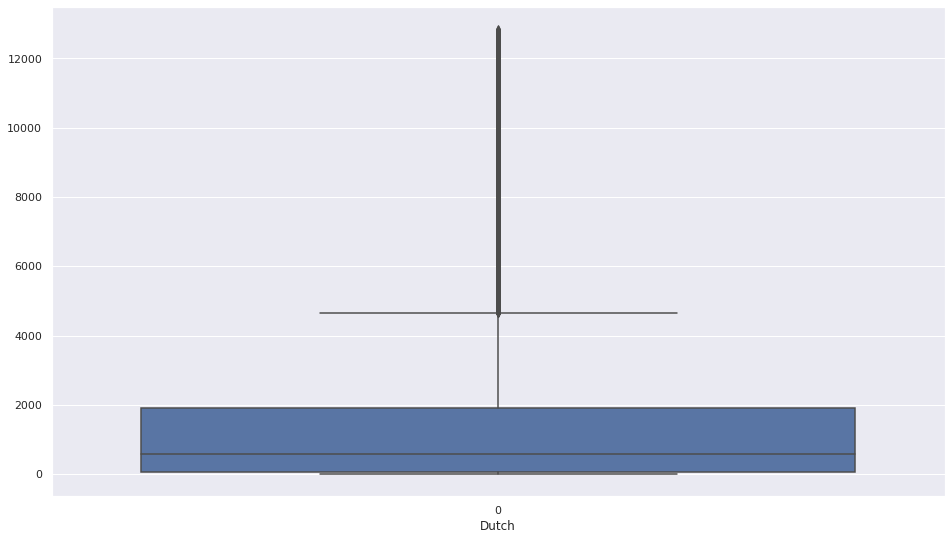

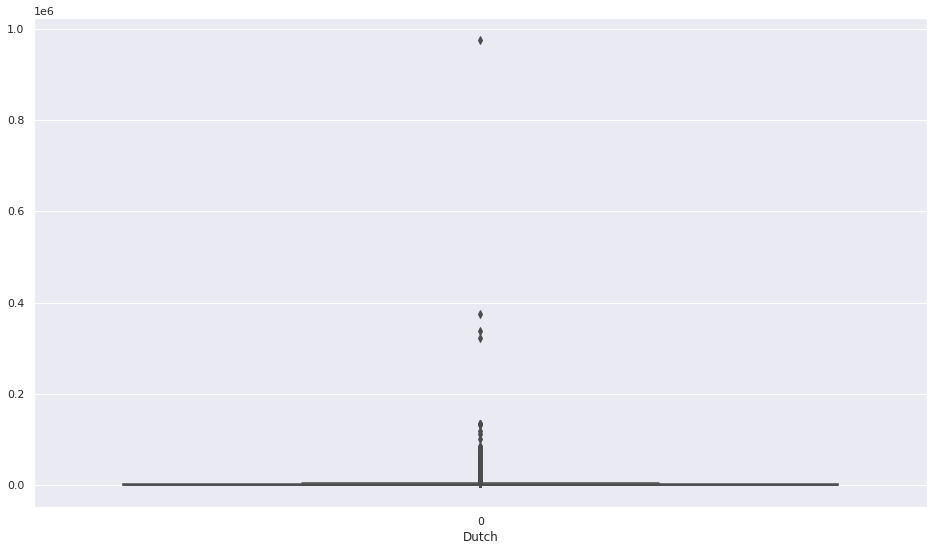

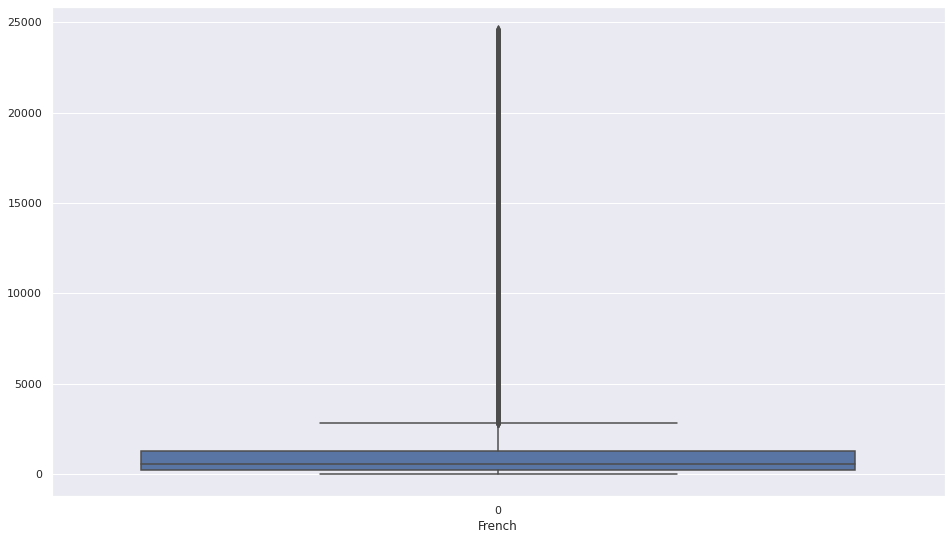

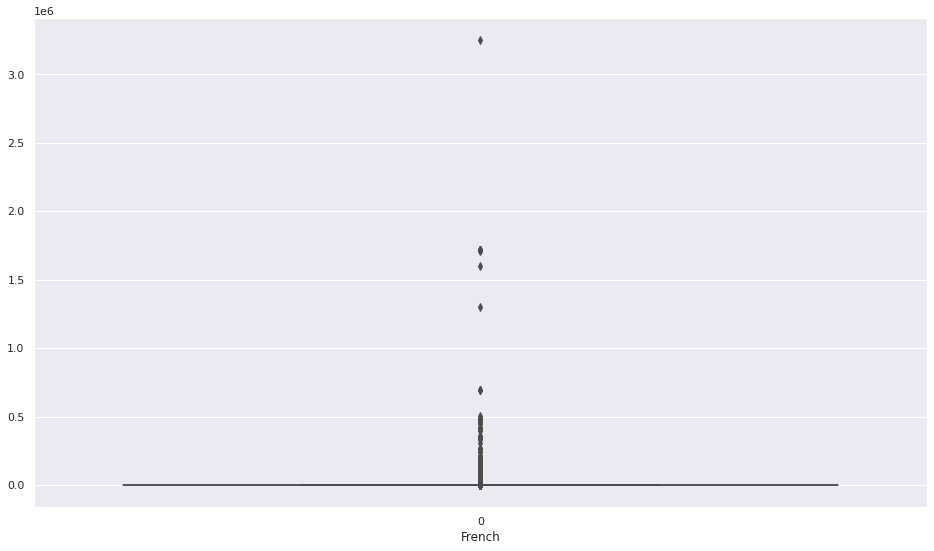

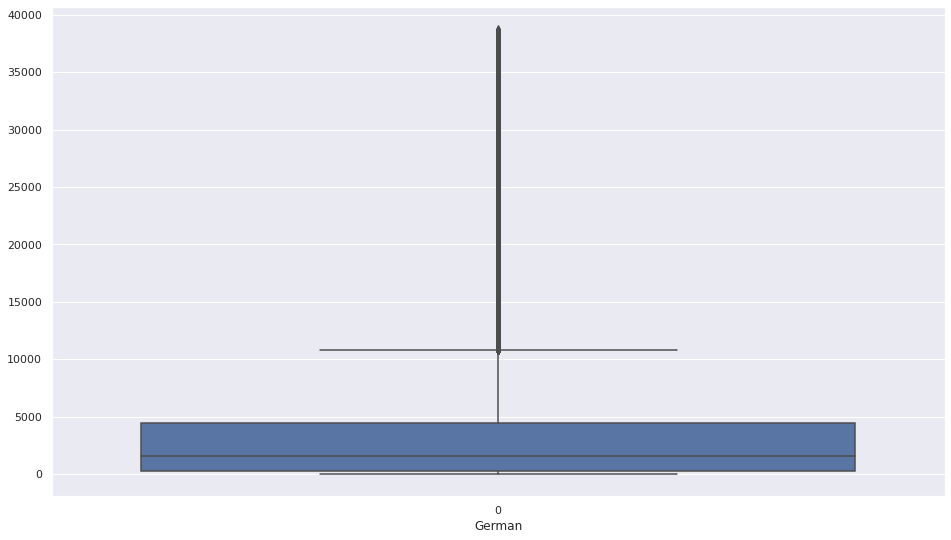

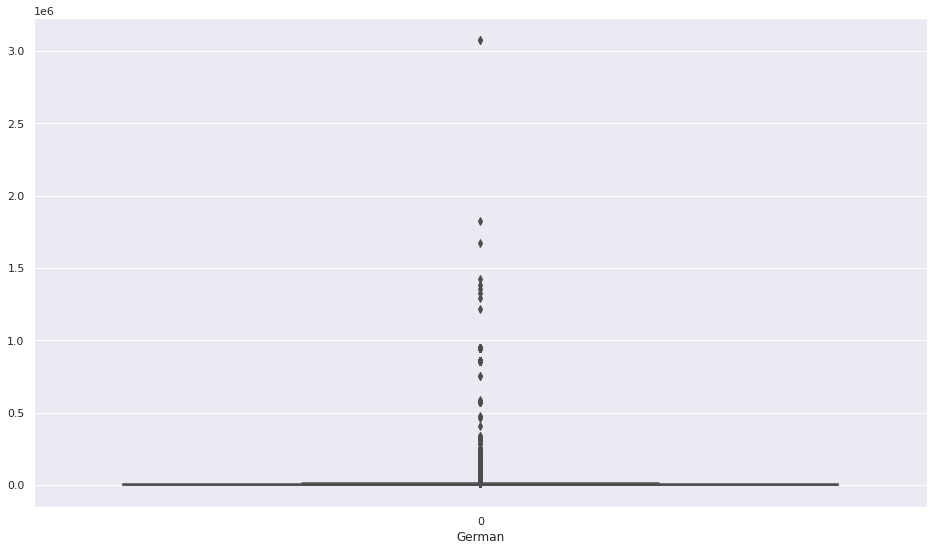

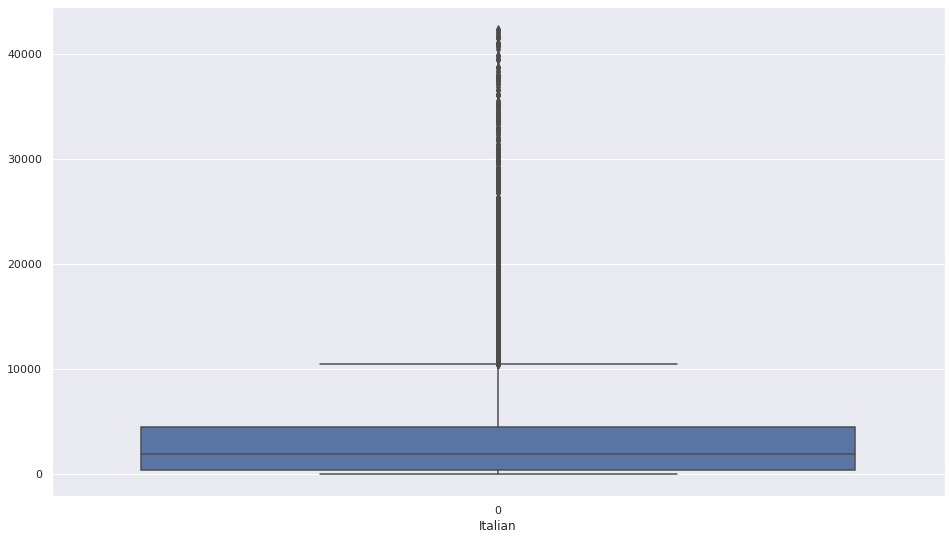

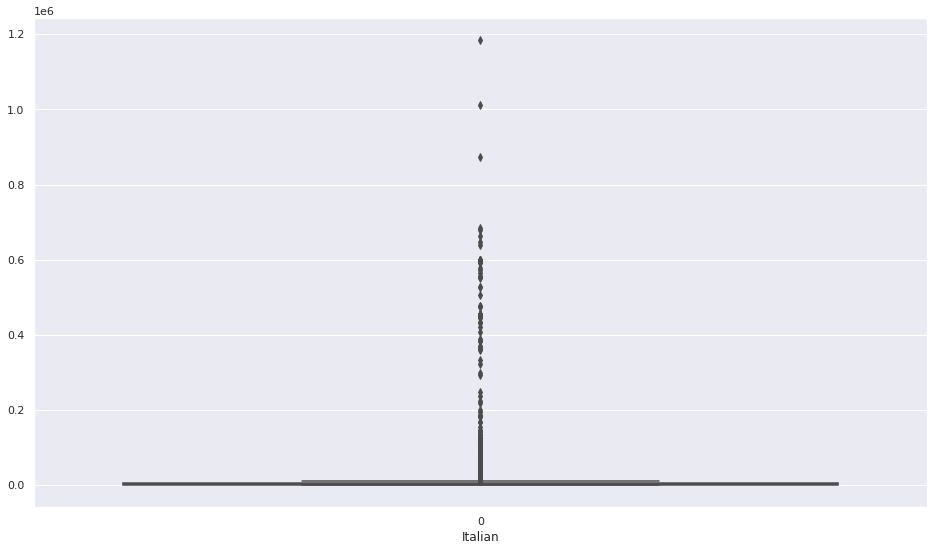

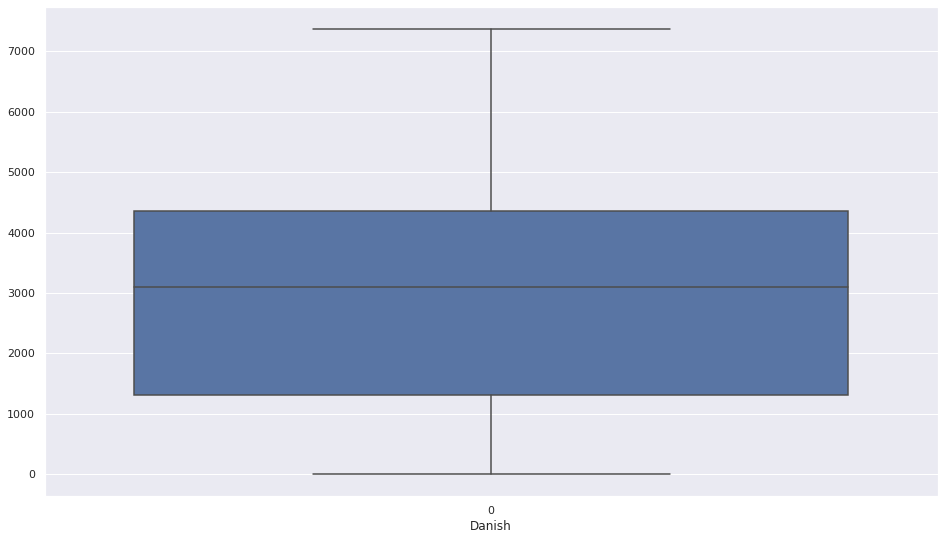

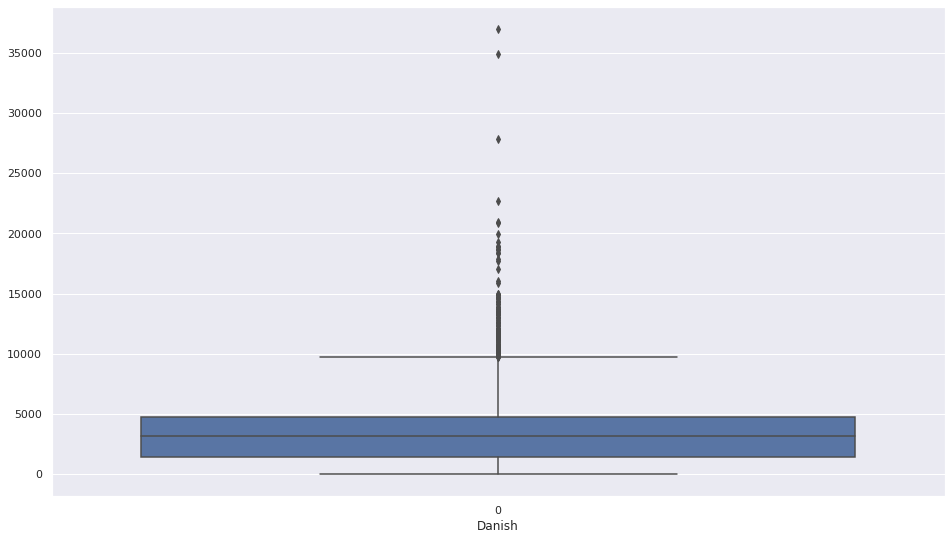

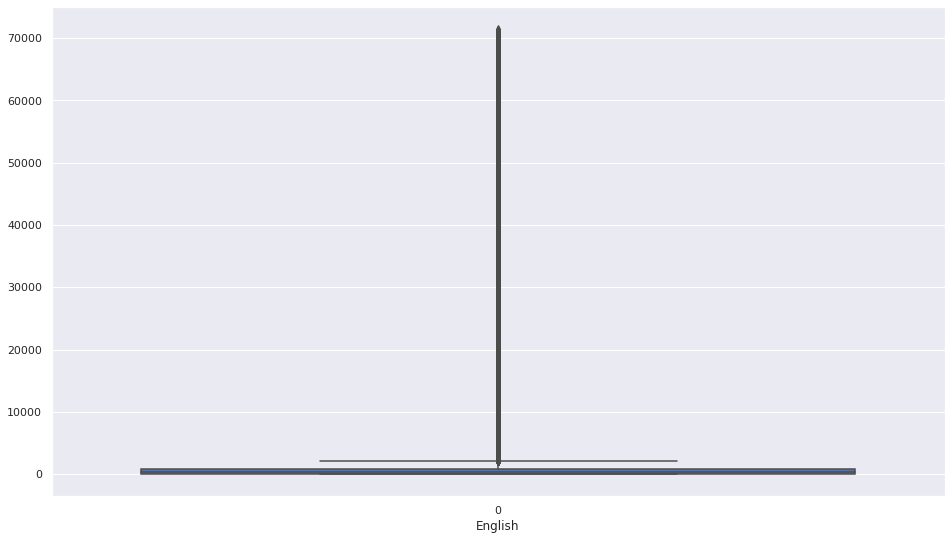

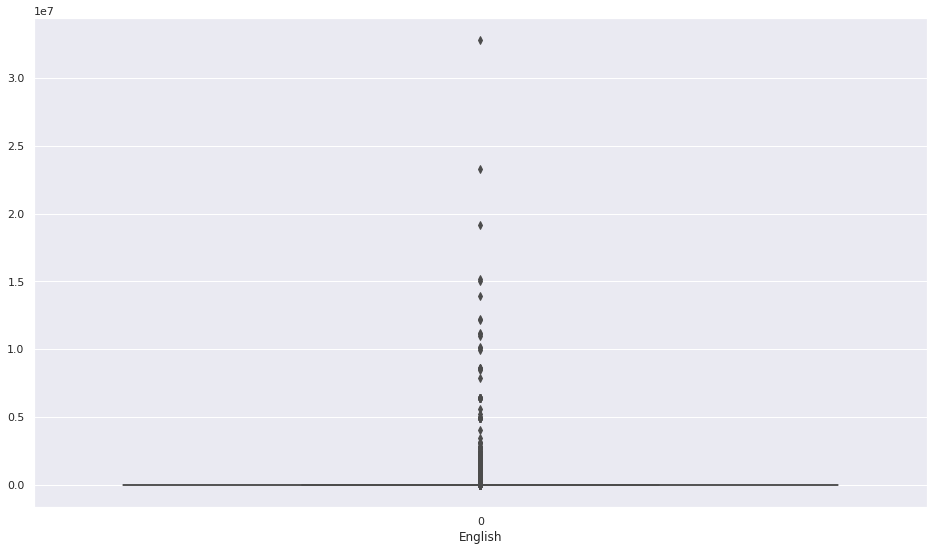

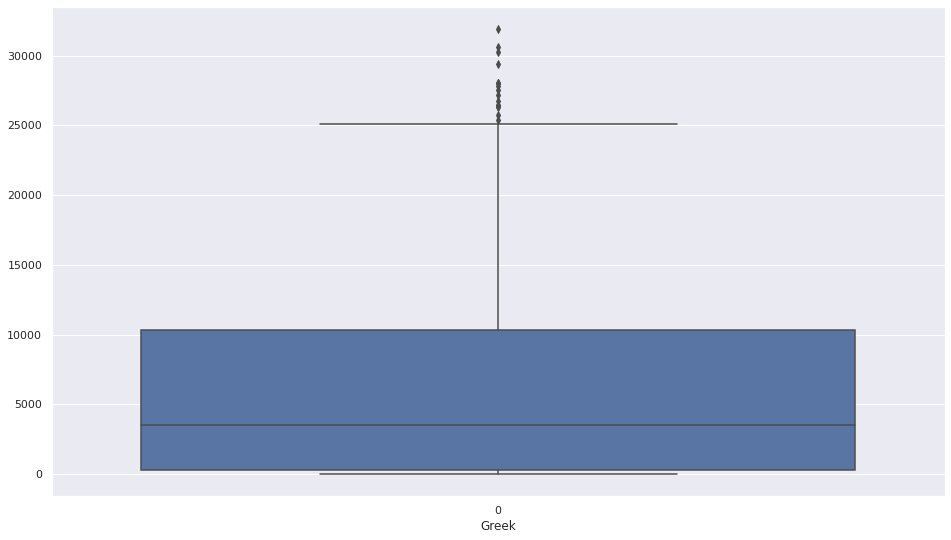

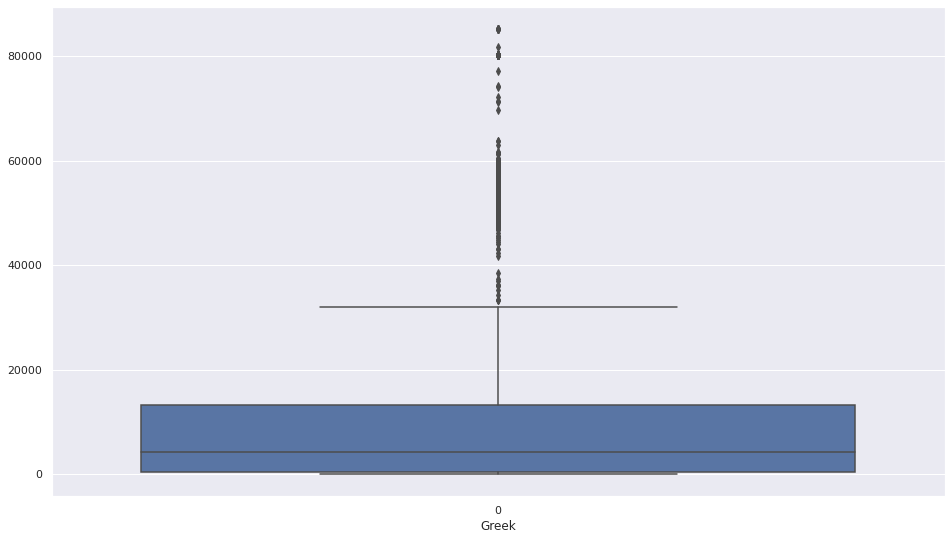

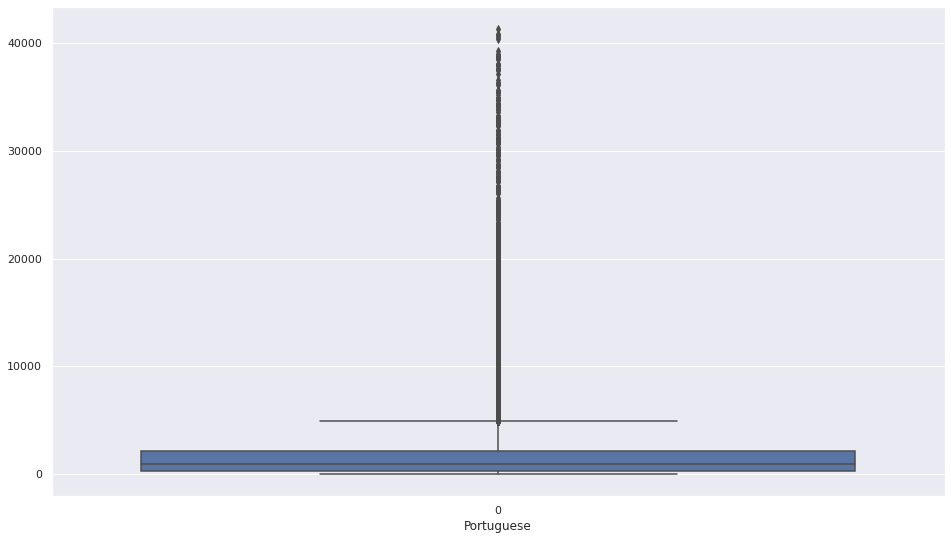

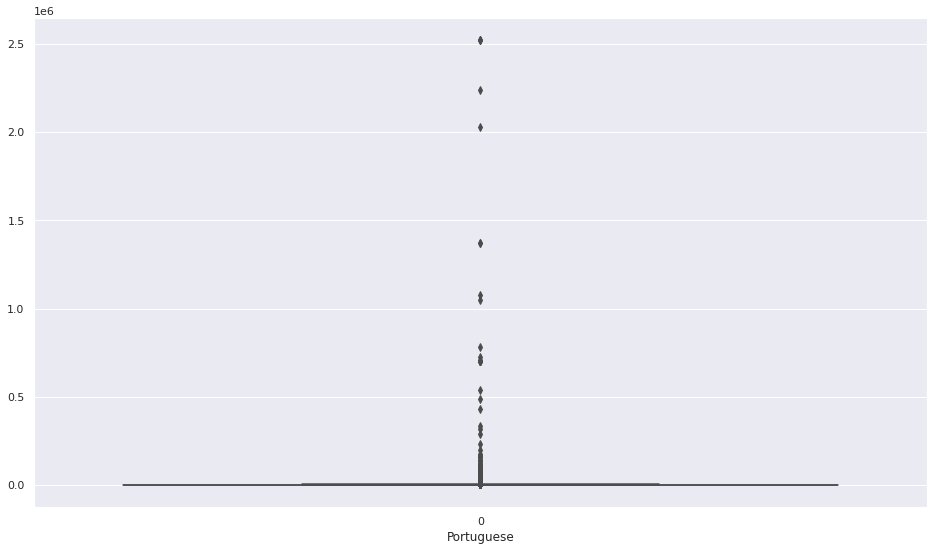

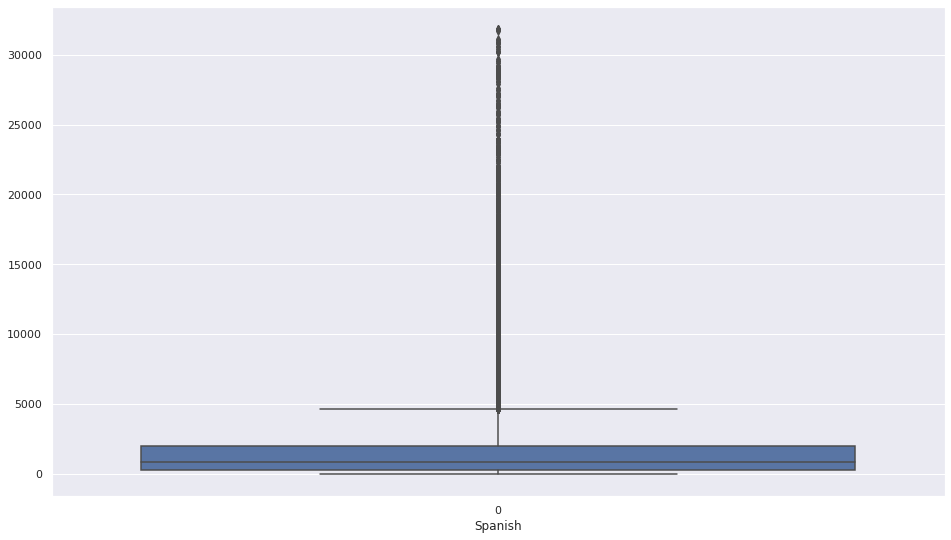

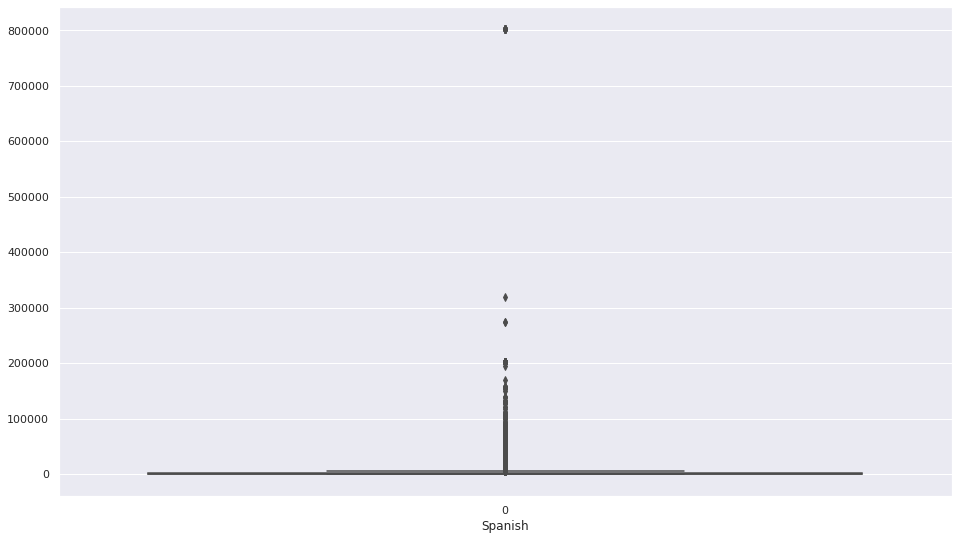

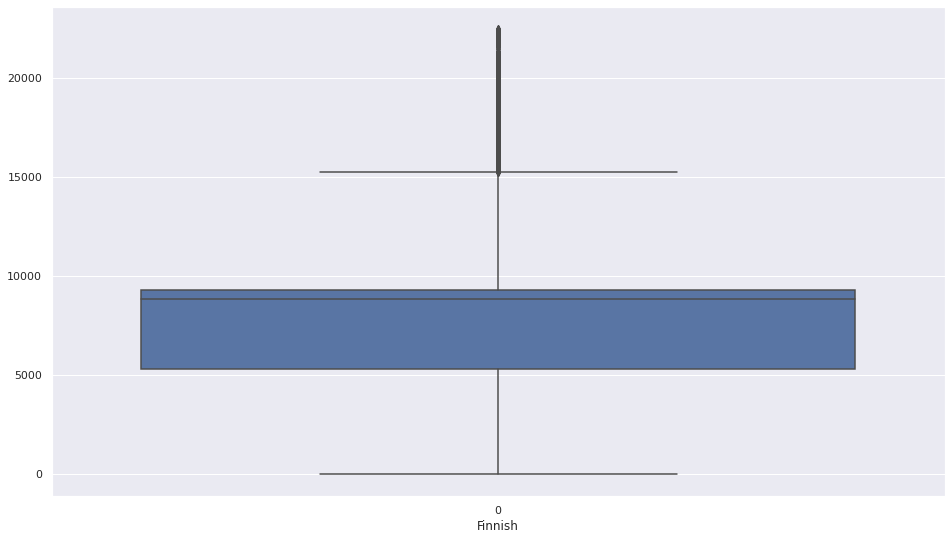

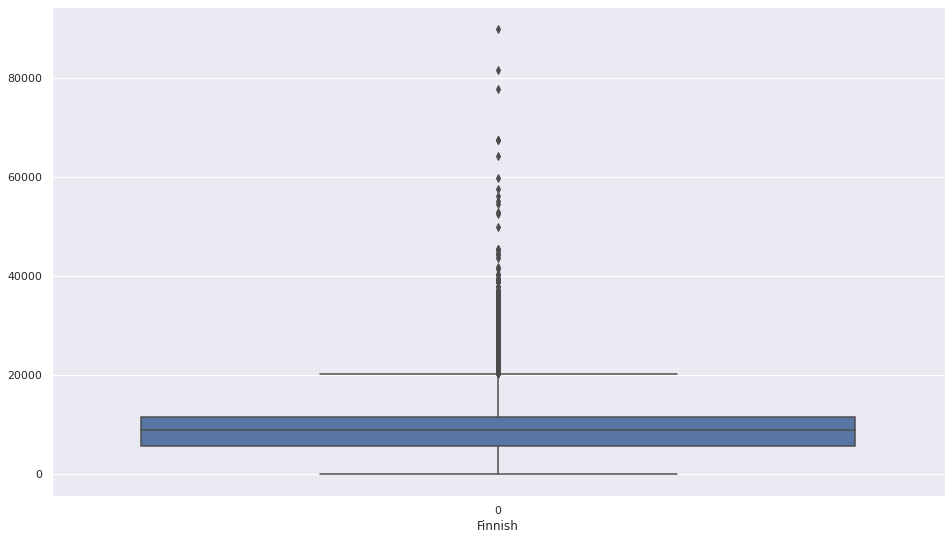

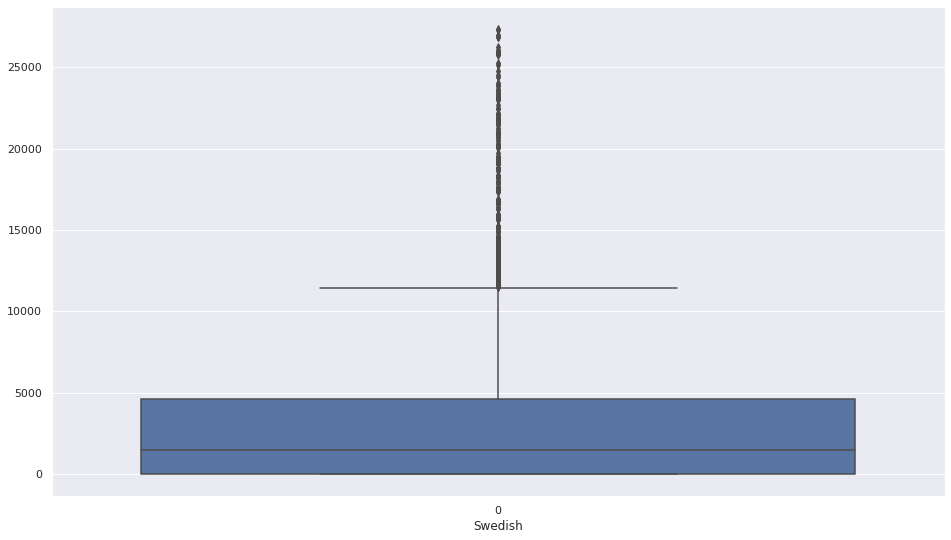

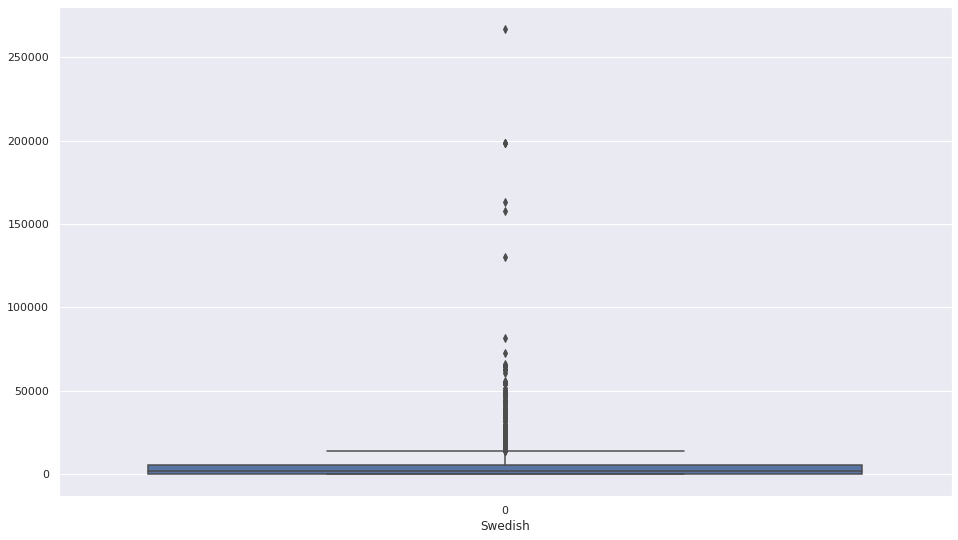

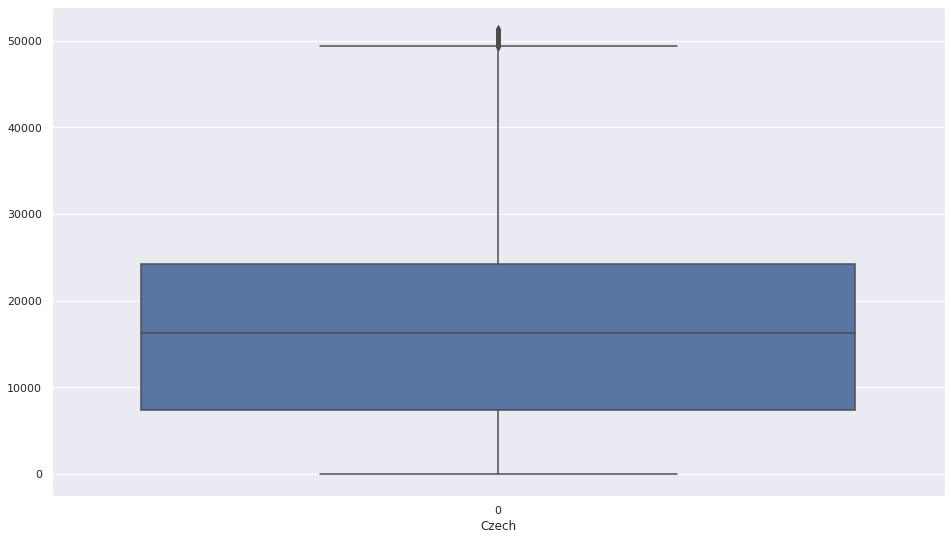

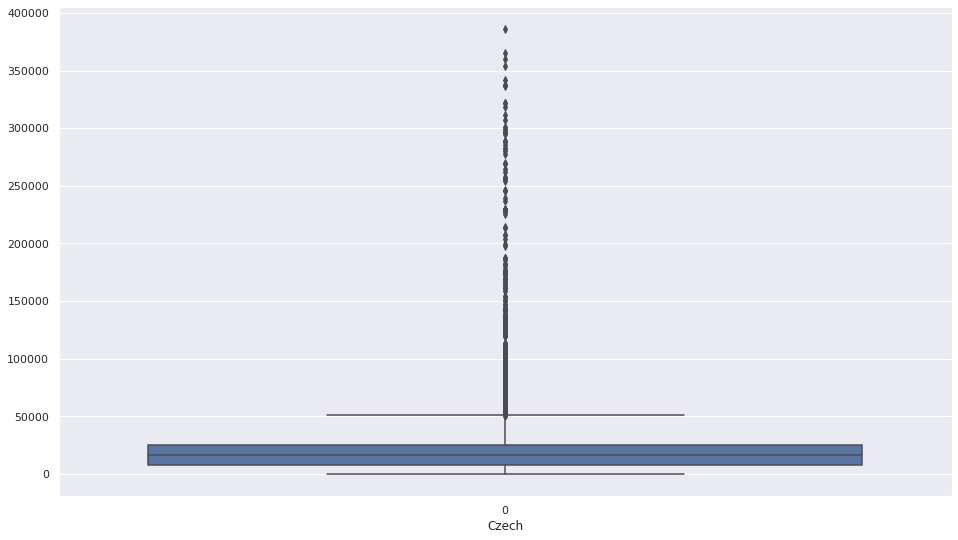

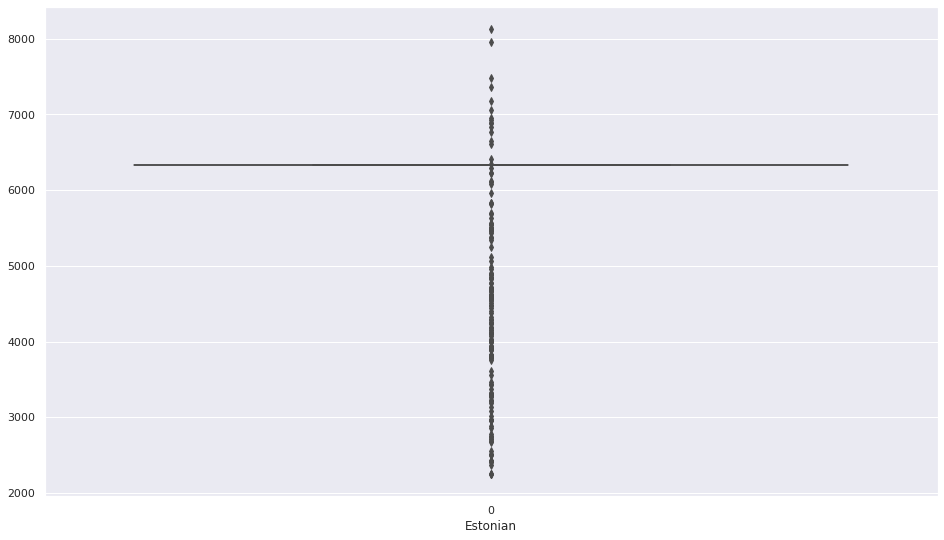

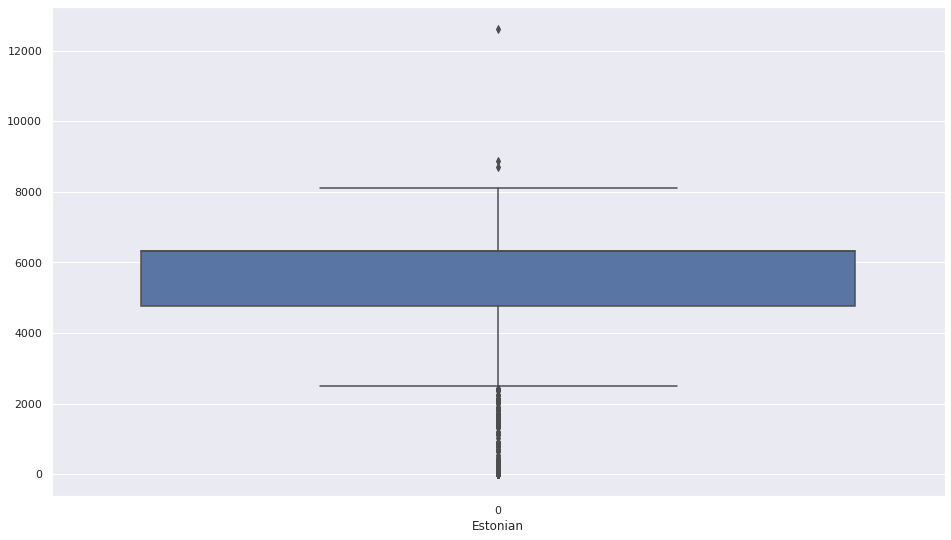

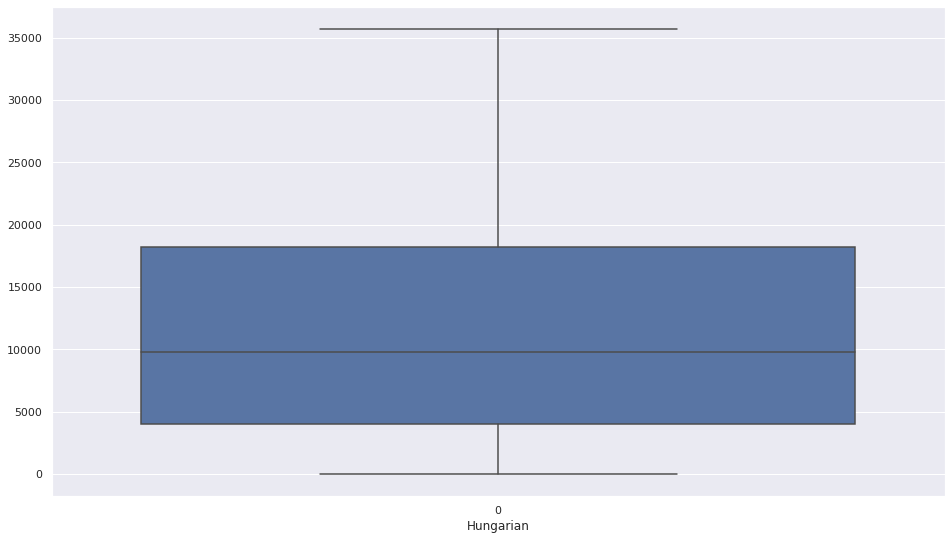

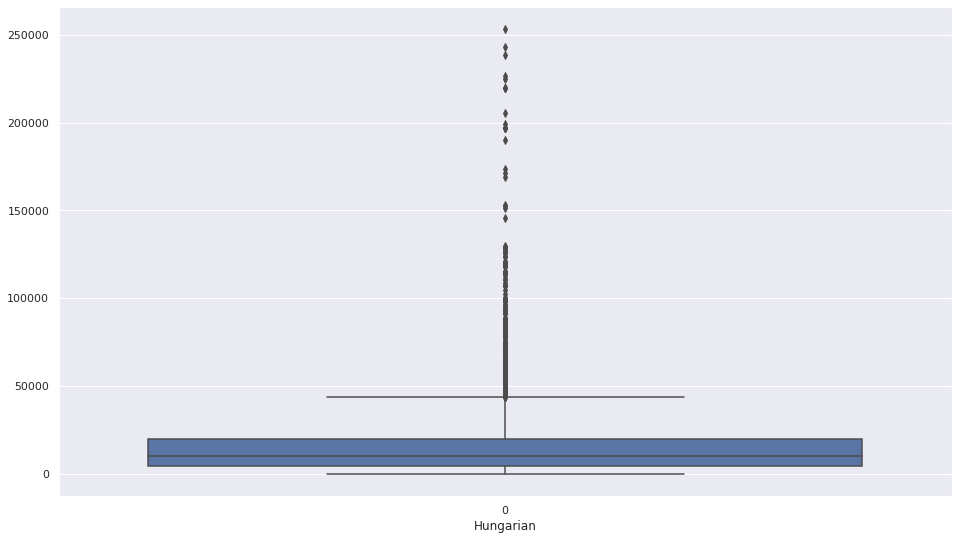

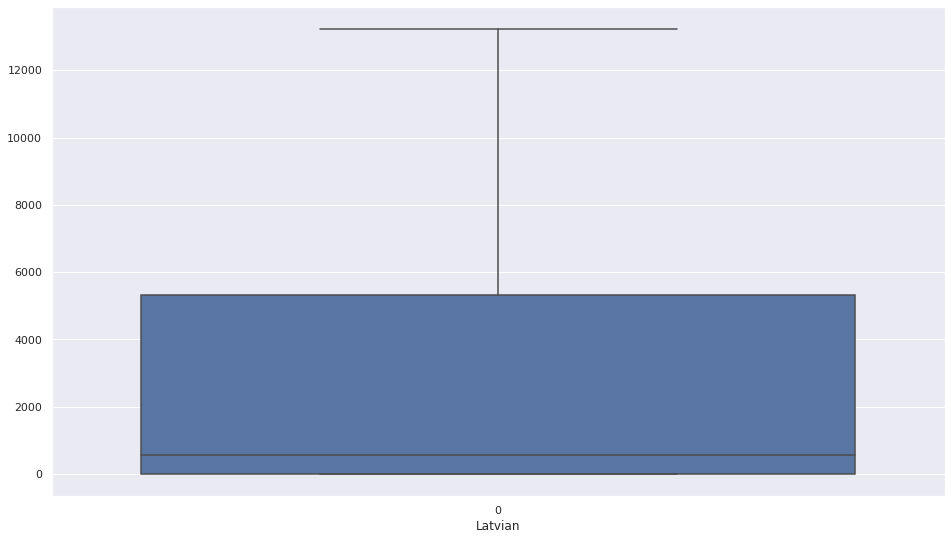

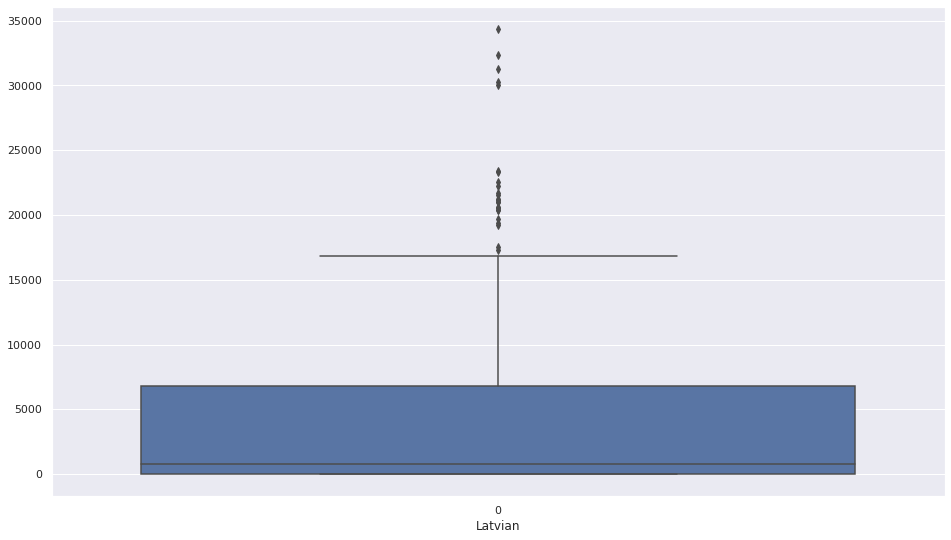

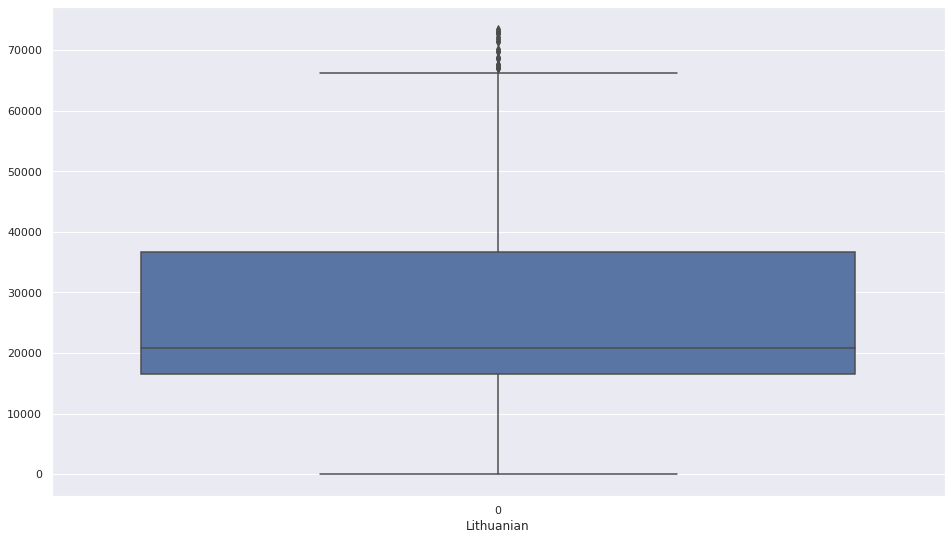

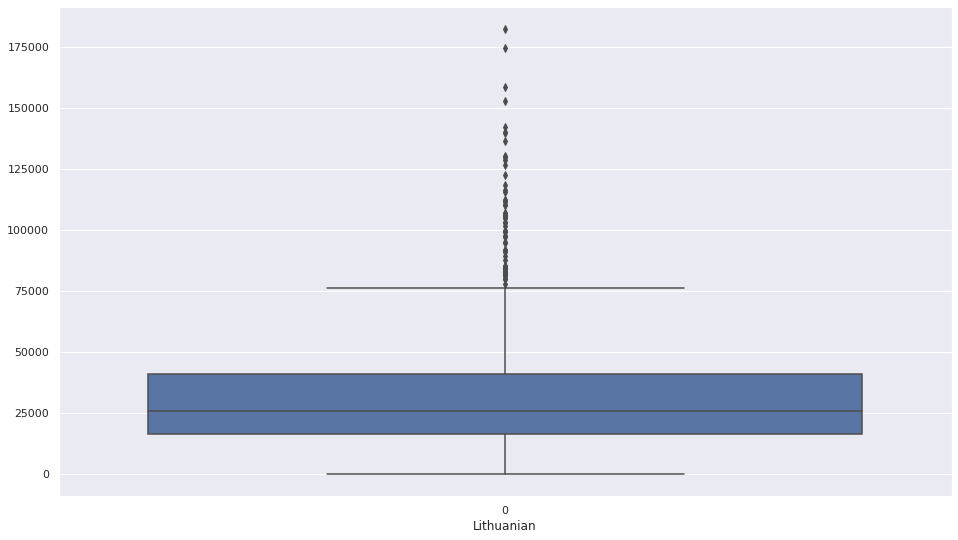

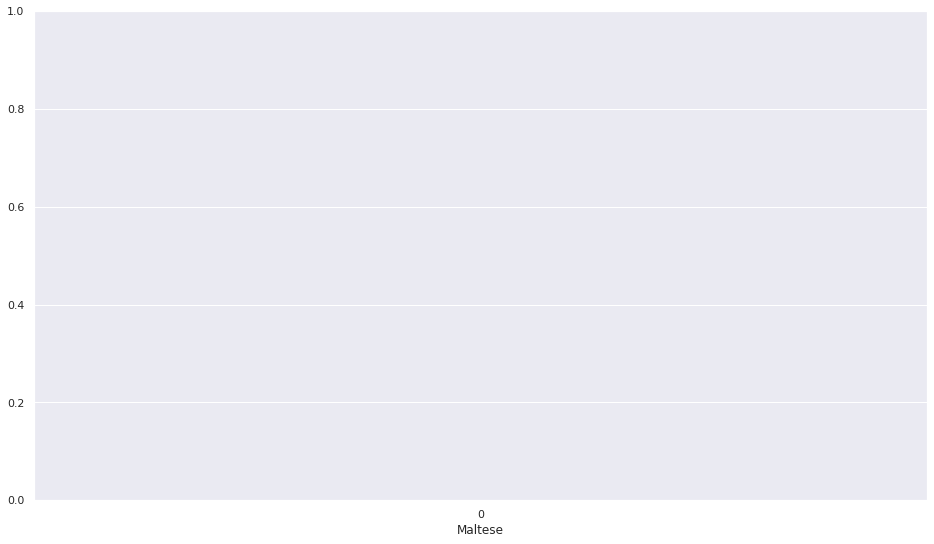

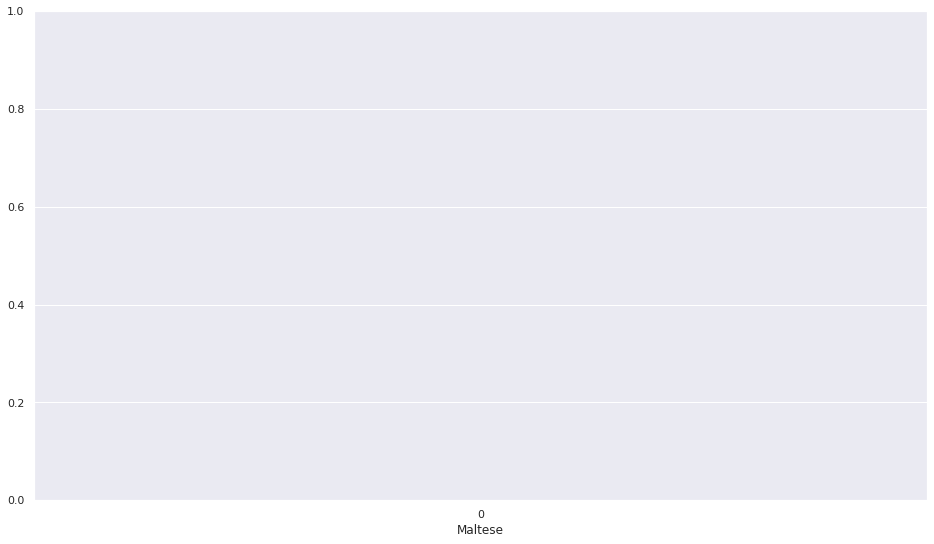

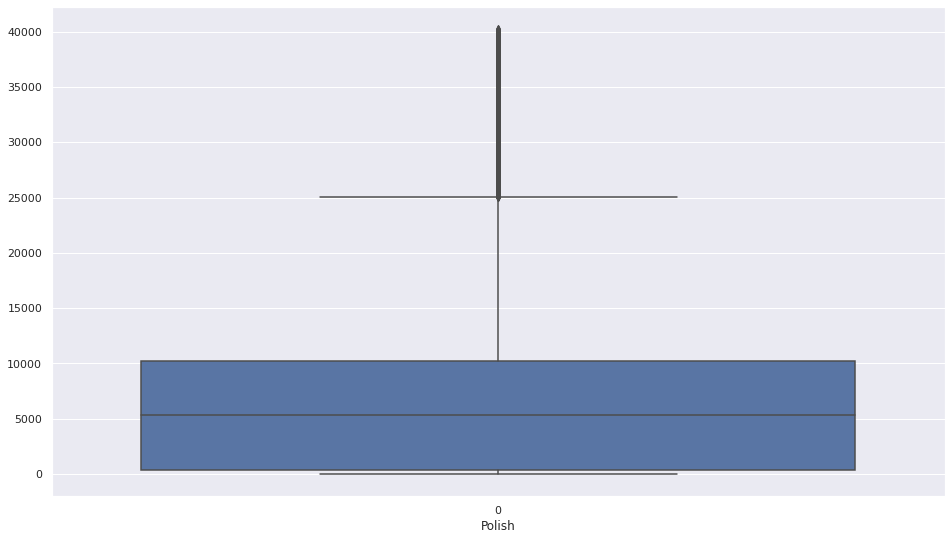

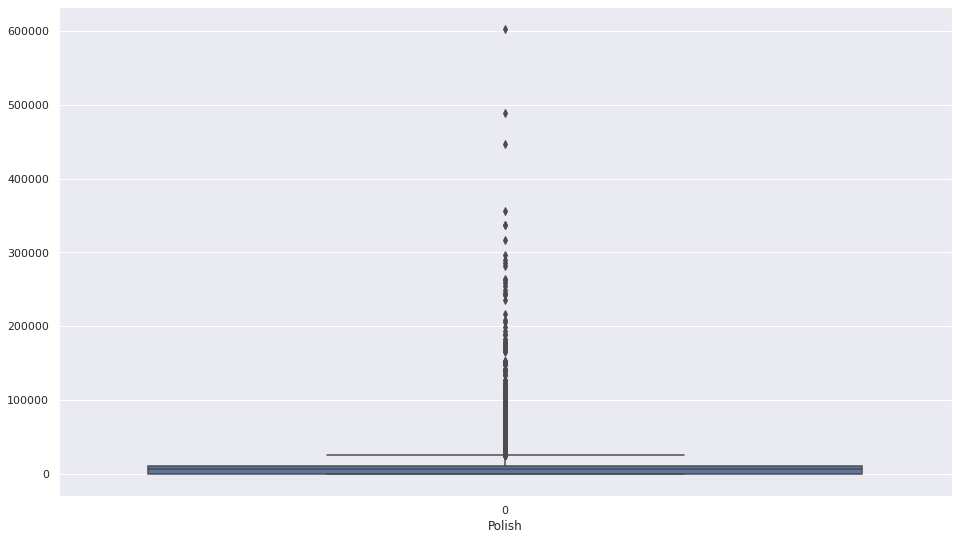

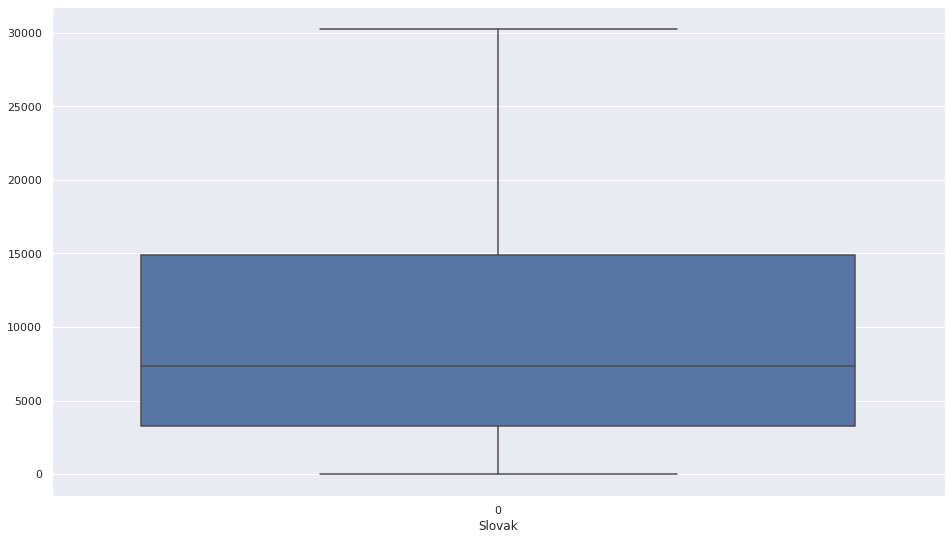

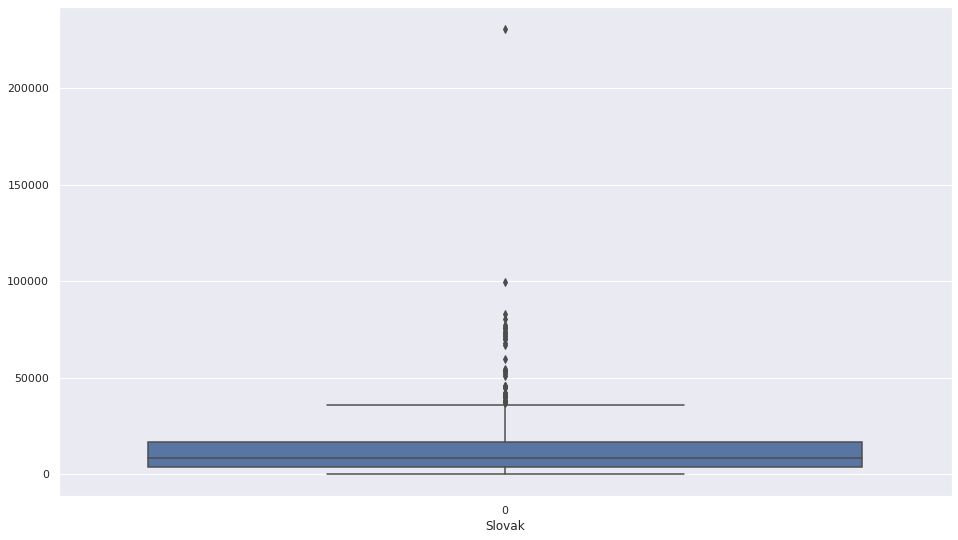

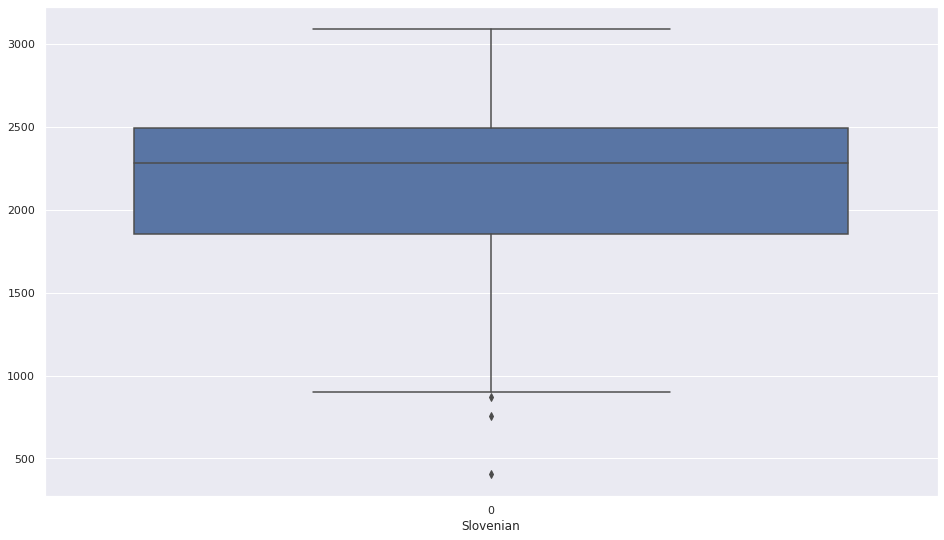

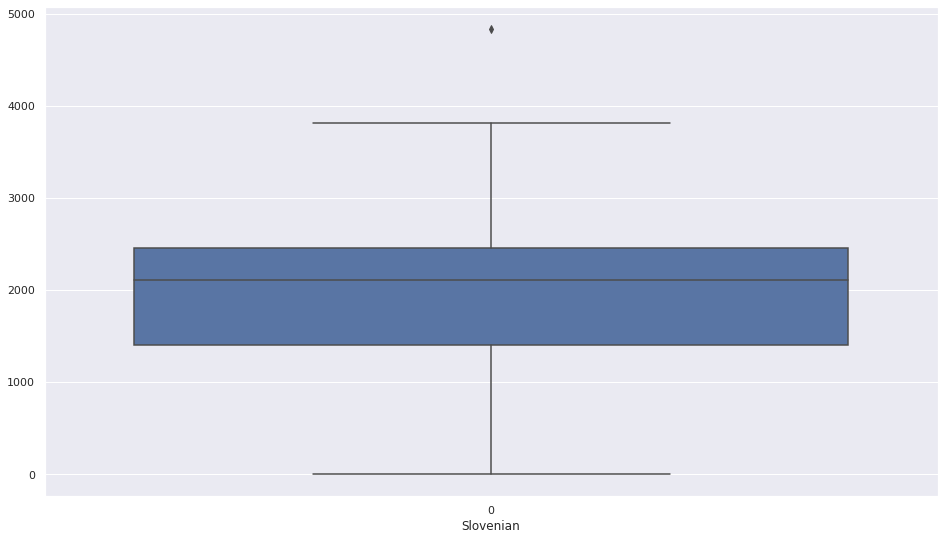

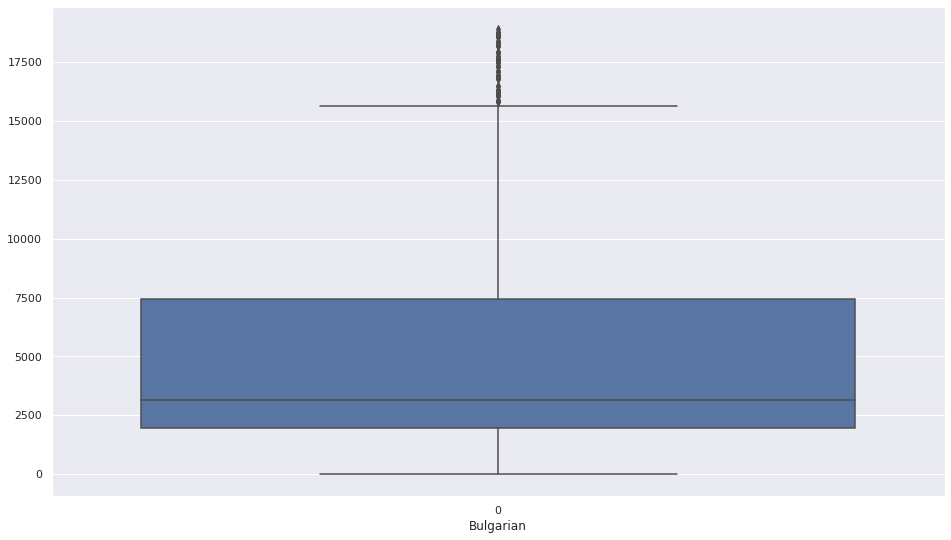

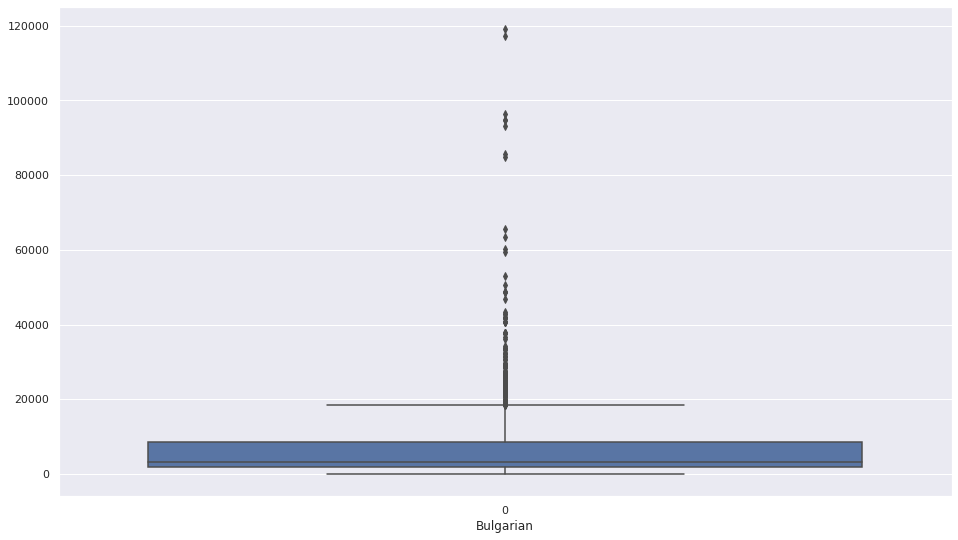

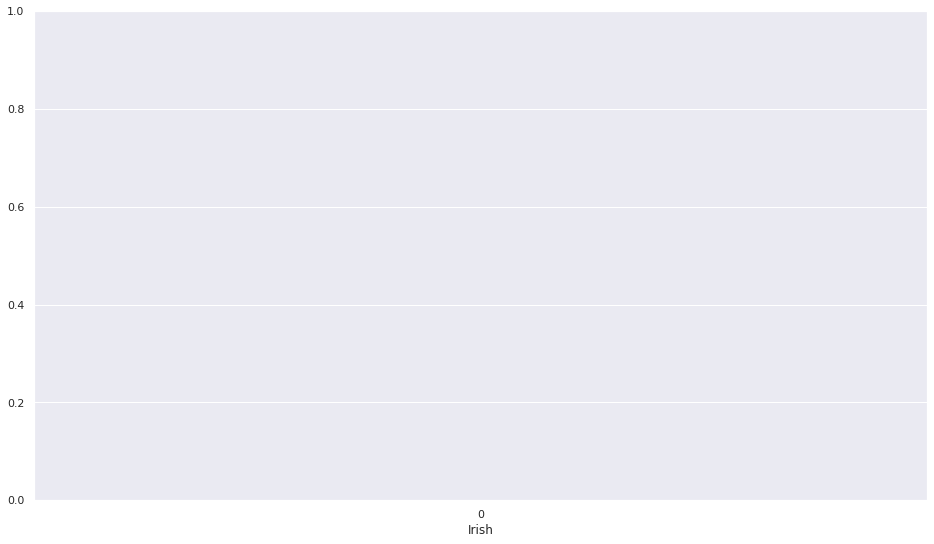

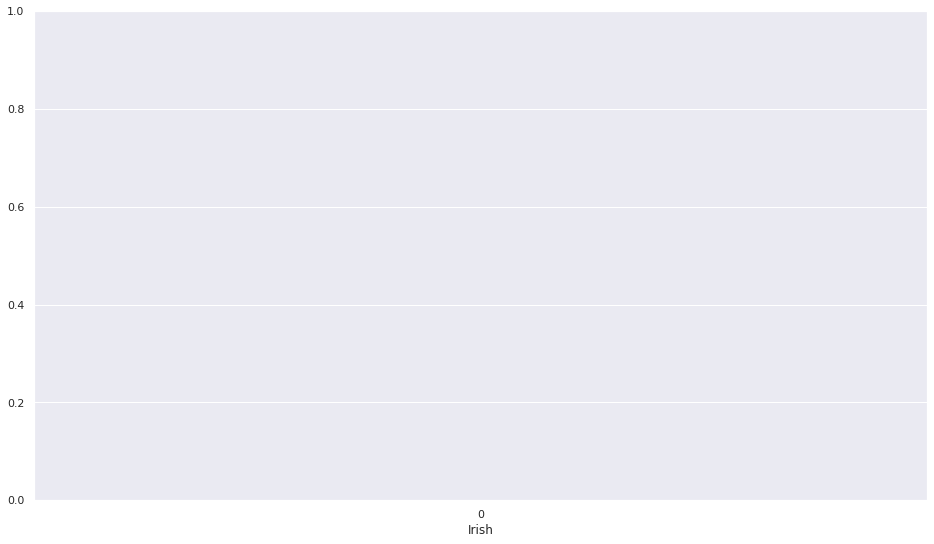

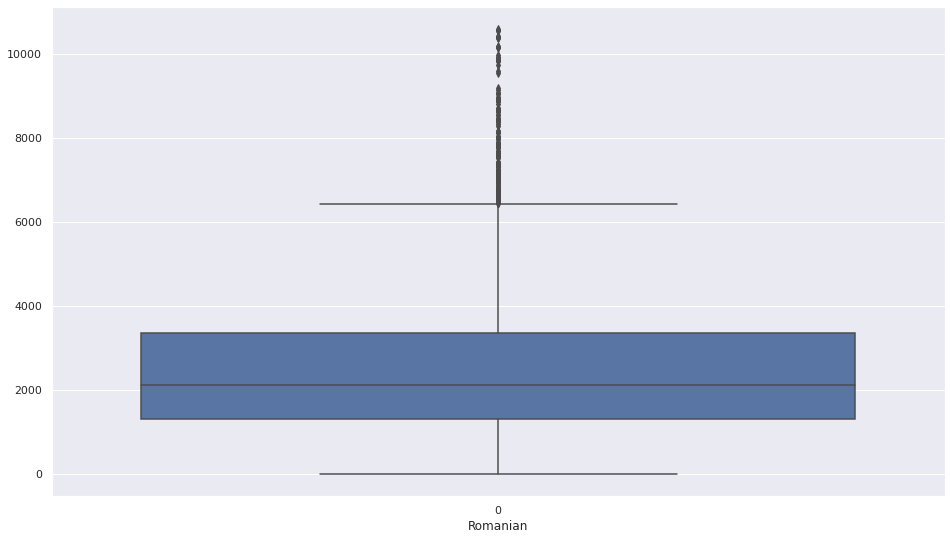

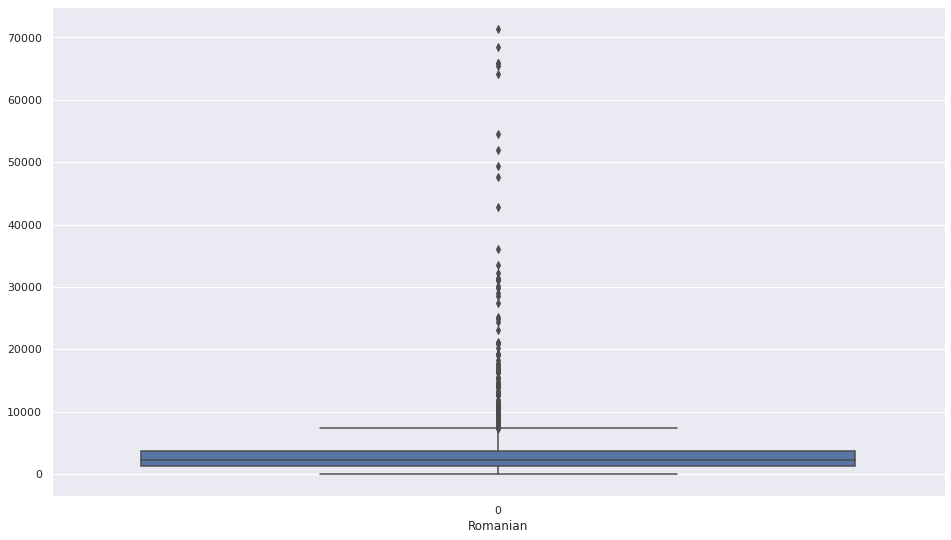

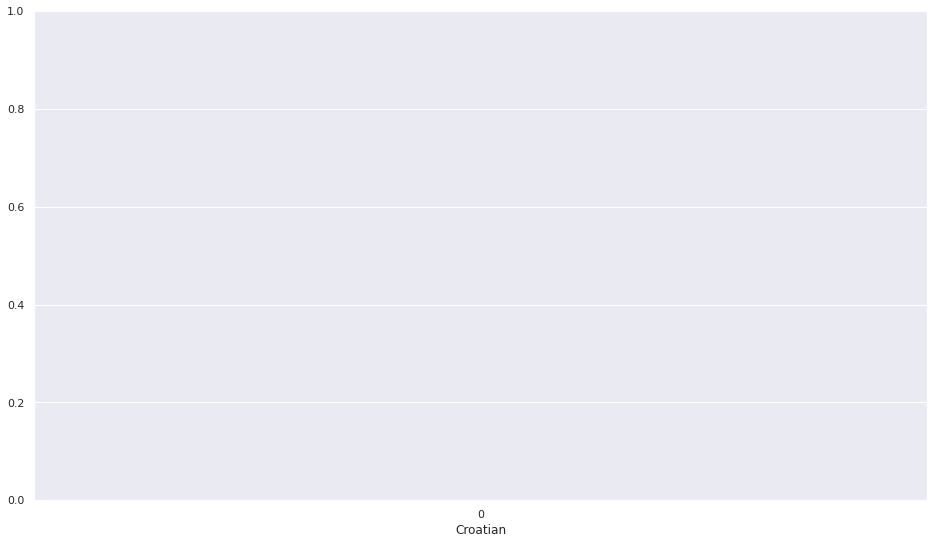

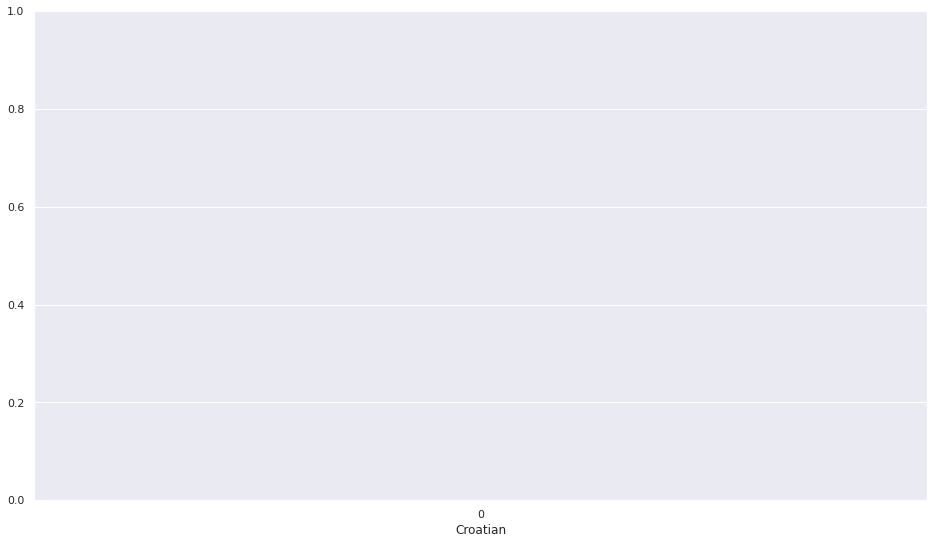

In [24]:
for language in europe_languages:
    sns.boxplot(filter_df[language])
    plt.xlabel(language)
    plt.show()
    sns.boxplot(df[language])
    plt.xlabel(language)
    plt.show()